In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Load, Split, and Balance (1.5 points total)
##### **[.5 points]**
* (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.

In [ ]:
#Read in the data
data = pd.read_csv('./acs2017_census_tract_data.csv', low_memory=False)
data.head()

* (2) Remove any observations that having missing data.

In [ ]:
# data.describe()
#Finding null values
print("Null Values before drop:\n")
print(data.isnull().sum())

data.dropna(axis=0,how="any",inplace=True)

print("\nNull Values after drop:\n")
print(data.isnull().sum())
# data.describe()

* (3) Encode any string data as integers for now.

In [ ]:
print("Categorical Features")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])
data_cat = data.copy() # Will be used later
states = data["State"]
counties = data["County"]
data["State"] = data["State"].astype('category')
data["State"] = data["State"].cat.codes
data["County"] = data["County"].astype('category')
data["County"] = data["County"].cat.codes

print("Features After encoding")
print(data.dtypes[data.dtypes != 'float64'][data.dtypes !='int64'])

* (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to remove the county data because we determined that it would not be as relevant as the other attributes in our dataset. Furthermore, we realized that if we were to keep it, we would need to one hot encode it as it is a cetegorical data type which would increase the number of attributes in our data signifigantly. Since a neural network's time complexist is based on the number of attributes, we decided that it would make more sense to remove the county variable completely.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We chose to remove variables such as TractId because it is an ID number and not relevant as a predictor of our classes. We also removed things such as race because we wanted to try to stray away from the model picking up a racial bias and wanted it to focus more on variables such as income and the types of industry in the given county.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We also removed data such as how people commute to work as we determined that this data would not be very important in predicting child poverty as the types of commuting vary drastically and would only really help to determine if a county has most of the population in a city or not and it is not a good indicator as to whether or not a county will have high child poverty. It was also necessary to convert data such as number of Men and number of Women to be percentages so that they were somewhat normalized because without doing this, then a county with a higher population will appear to have more women and men than another county with lower pop. Finally, we removed data about the number of people over the age of 16 who are employed because it is already accounted for in the unemployment rate attribute and by leaving it in, we would create a stronger bias for that data without meaning to.<br/>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__NOTE:__ It may be worth while to add this data in back in the end to see if it was increases our accuracy but for now, we will leave it out. 

In [ ]:
#Data Cleaning
#Drop Non important columns
data.drop(columns=['TractId','Hispanic','White','Black','Native','Asian','Pacific','Employed','MeanCommute','OtherTransp','Walk','Transit','Carpool','Drive','County'],inplace=True)


#Numerical Data into percentages so that it is not skewed by population
data['Men'] = data['Men'] / data['TotalPop']
data['Women'] = data['Women'] / data['TotalPop']
data['VotingAgeCitizen'] = data['VotingAgeCitizen'] / data['TotalPop']
data.describe()

#### Determining the cutoff for our Categories of child poverty
##### [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided to go with pandas built in qcut function which is able to evenly divide any given series into n bins. Since we want 4 types of targets, we gave the function the number 4 for n and it ends up being the cutoff for the quartile ranges of the data. Meaning that the first bin, low child poverty, is the values from the 0th to 25th quartile and the moderate variable is the values from the 25th quartile to the 50th so on and so forth. By doing this, we are left with a roughly equivalent number of entries in each target variable. This is extremely important for the training data because without it, the model could only be good at looking at low poverty rates and would have little data to go off of in the high or extreme categories for example. This idea is not so important for the testing data because when testing, the model should be able to generalize such that it does not need an equivalent number of each class as it is not actively learning from the data and would therefore not be skewed one way or the other. I would argue that it is almost beneficial to have an uneven number of each category in the testing set because that can show if the model is able to generalize well or not.

In [ ]:
#Coming up with divisors for child poverty

tmp = pd.qcut(data['ChildPoverty'],4,labels=[1, 2, 3, 4])
# tmp = pd.qcut(data['ChildPoverty'],4,labels=['low','moderate','high','extreme'])
data['ChildPoverty'] = tmp
print(data.groupby(['ChildPoverty']).size())

In [ ]:
data.columns

##### [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.

In [ ]:
# One-Hot Encodes
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f'Train_data shape: {train_data.shape} - {train_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Train_data classes:\n',train_data.groupby(['ChildPoverty']).size()) #Ensure that the number of classes stays relatively equivalent
print(f'\nTest_data shape: {test_data.shape} - {test_data.shape[0] / data.shape[0] * 100:.2f}% of original data')
print('Test_data classes:\n',test_data.groupby(['ChildPoverty']).size())

y_train = pd.DataFrame(train_data['ChildPoverty'])
y_train = y_train.values.ravel()
X_train = train_data.drop(columns=['ChildPoverty'],inplace=False)
X_train = np.array(X_train)
# y_train = encode_and_bind(y_train,'ChildPoverty')

y_test = pd.DataFrame(test_data['ChildPoverty'])
y_test = y_test.values.ravel()
X_test = test_data.drop(columns=['ChildPoverty'],inplace=False)

X_test=np.array(X_test)
# y_test = encode_and_bind(y_test,'ChildPoverty')


print()
print(f'Type of X: {type(X_train)}\nType of y: {type(y_train)}\n')

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Targets:', np.unique(y_train))
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

y_test = y_test - 1
print(np.unique(y_test))
y_train = y_train - 1
print(np.unique(y_train))

## Pre-processing and Initial Modeling (2.5 points total)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will be using a two layer perceptron for the next few parts. The perceptron uses the following properties:
1. Vectorized Gradient Computation
2. Mini-Batching
3. Cross Entropy Loss
4. Proper Glorot Initialization
5. Sigmoids

##### Two Layer Perceptron Code

In [ ]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd



class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,C=0.0,epochs=500,eta=0.001,random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    @staticmethod
    def _encode_labels(y):
        return pd.get_dummies(y).values.T

    def _initialize_weights(self):
        W1_num_elems = (self.n_features_ + 1) * self.n_hidden
        W1 = np.random.uniform(-1.0,1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden,self.n_features_ + 1)

        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0,1.0,size=W2_num_elems)
        W2 = W2.reshape(self.n_output_,self.n_hidden + 1)
        return W1,W2
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [ ]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        # print(f"========== A3.shapoe {A3.shape}")
        y_pred = np.argmax(A3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""

        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)

            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2


        return self

In [ ]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T


        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [ ]:
import matplotlib.pyplot as plt
params = dict(n_hidden=50,
              C=0, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

### Basic Network
This network is only capable of vectorized gradient computation, not the other aspects as we wanted to take a deeper look at how each attribute of the network affects the accuracy score. We can see that the accuracy is quite low as it only predicts a single class. Furthermore, upon inspecting the cost function, it has a steep drop after about 150 iterations. This is most likely due to the fact that the data was unscaled when the network saw it but we will be looking further into the reasons later in this document

In [ ]:
%%time
nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)

print(np.unique(yhat))
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)),nn.cost_)
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [ ]:
#Mini Batching
class MiniBatchedTwoLayer(TwoLayerPerceptronVectorized):
    def __init__(self,minibatches=1,shuffle=False,alpha=0.1,decrease_const=0.0, **kwargs):
        self.minibatches = minibatches
        self.shuffle = shuffle
        self.alpha = alpha
        self.decrease_const = decrease_const
        super().__init__(**kwargs)
    def fit(self,X,y,print_progress =0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)


        self.cost_ = []

        for k in range(self.epochs):

            eta = self.eta **(1+self.decrease_const*k)
            eta = max(eta,self.eta/1000)

            if print_progress >0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                # print(ridx)
                # print(f"X: {X_data.shape} | y: {Y_enc.shape} | y_data: {y_data.shape}")

                X_data, Y_enc = X_data[ridx], Y_enc[:,ridx]

            mini = np.array_split(range(y_data.shape[0]),self.minibatches)
            mini_cost = []
            for idx in mini:
                A1, Z1 ,A2 , Z2, A3 = self._feedforward(X_data[idx],
                                                        self.W1,
                                                        self.W2)

                cost = self._cost(A3,Y_enc[:,idx],self.W1,self.W2)
                mini_cost.append(cost)

                grad1, grad2 = self._get_gradient(A1=A1,A2=A2,A3=A3,Z1=Z1,Z2=Z2,Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)
                rho_W1,rho_W2 = eta * grad1, eta *grad2
                self.W1 -=(rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1,rho_W2


            self.cost_.append(mini_cost)
        return self







### Mini Batching Network
This network utilizes mini batching as well as a cooling momentum function to lower eta as the number of iterations increases. As we can see, the accuracy is still not great and the cost function is all over the place. This is again most likely due to the fact that none of the data is scaled correctly before our network sees it. The accuracy is also similar but the cost is drastically different. This is due to the fact that the cost function is averaged across every mini batch that we do which will increase the variance, especially when the model is unable to get a good grasp of what factors are playing into the class label because some are weighted much heavier than others.

In [ ]:
#Testing Mini Batching

params['epochs'] = 100
params['eta'] = 0.1

nn_mini = MiniBatchedTwoLayer(**params,
                              minibatches=len(X_train)/32,
                              shuffle=True)
nn_mini.fit(X_train,y_train,print_progress=25)
yhat = nn_mini.predict(X_test)

print(np.unique(yhat))
print(f'Accuracy: {accuracy_score(y_test,yhat)}')

In [ ]:
#Graphing Cost Funciton over Epochs

cost_avgs = [np.mean(x) for x in nn_mini.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [ ]:
# Cross Entropy Loss
import math
class CrossEntropyLossTwoLayer(MiniBatchedTwoLayer):
    def  _cost(self,A3,Y_enc,W1,W2):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc)*np.log(1-A3))))

        return cost
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        # print("============")

        V2 = (A3-Y_enc)
        V1 = A2*(1-A2) * (W2.T @V2)


        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:,1:] += W1[:, 1:] * self.l2_C
        grad2[:,1:] += W2[:,1:] * self.l2_C

        return grad1,grad2

### Addition of Cross entropy
This new network also leverages cross entropy as a cost function instead of mean squared error. Again we can see that the model basically predicts each class being .25 probability which is a pretty useless model. We believe that because of the unscaled data, the model is getting stuck in a local minimum and cannot get outside it without scaling the data first.

In [ ]:
params['epochs'] = 100
params['eta'] = 0.1

nn_cross_entropy = CrossEntropyLossTwoLayer(**params,
                              minibatches=len(X_train)/32,
                              shuffle=True)
nn_cross_entropy.fit(X_train,y_train,print_progress=25)
yhat = nn_cross_entropy.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,yhat)}')

In [ ]:
cost_avgs = [np.mean(x) for x in nn_cross_entropy.cost_]


# print(np.unique(cost_avgs))
plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [ ]:
# Glorot initialization

class FullyFledgedTwoLayer(CrossEntropyLossTwoLayer):
    def _glorot_init_matrix(self,shape):
        fan_in, fan_out = shape[0],shape[1]
        variance = 2.0 / (fan_in + fan_out)
        std = np.sqrt(variance)
        return np.random.normal(loc=0.0,scale=std,size=shape)

    def _initialize_weights(self):
        W1 = self._glorot_init_matrix((self.n_hidden,self.n_features_ + 1))
        W2 = self._glorot_init_matrix((self.n_output_,self.n_hidden + 1))

        return W1,W2


In [ ]:
params = dict(C=0.1,
              epochs=100,
              eta=0.05,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=50,
              shuffle=True,
              random_state=4)

##### **[.5 points]** Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.

### The final 2 layer network
This final edition of the 2 layer network also takes advantage of proper glorot initialization. This initialization technique is better than a normal distribution because it makes sure that the variance of each weight set is similar to the others. We finally see a converging cost function but our accuracy is still not great. Until we are able to scale the data, I do not expect that our accuracy will be any better than just guessing because certain columns are weighted much heavier than others which cause the network to be unable to determine which factors are the most important.

In [ ]:
%%time
mlp1 = FullyFledgedTwoLayer(**params)

mlp1.fit(X_train, y_train)
yhat = mlp1.predict(X_test)

print("Accuracy:", accuracy_score(yhat, y_test))

In [ ]:
cost_avgs = [np.mean(x) for x in mlp1.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='blue')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

##### **[.5 points]** Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

### Scaling the data
We are finally able to really put our network to the test now that we can scale the data to attempt to get a decent accuracy. We used the standard scalar function from scikit-learn to do this as it is the easiest to use. 

In [ ]:
print('X_train before normalization:', np.min(X_train), np.max(X_train))
print('X_test  before normalization:', np.min(X_test), np.max(X_test))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print('X_train after normalization:', np.min(X_train), np.max(X_train))
print('X_test  after normalization:', np.min(X_test), np.max(X_test))

In [ ]:
%%time
mlp2 = FullyFledgedTwoLayer(**params)

mlp2.fit(X_train, y_train)
yhat = mlp2.predict(X_test)

print("Accuracy:", accuracy_score(yhat, y_test))

In [ ]:
cost_avgs = [np.mean(x) for x in mlp2.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='red')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

### Scaled Model Analysis
As we can see, once the data was scaled, our model performed MUCH better than before it was scaled. We get a 68% accuracy and as we can see in the above visualization, the cost function converges after about 10 epochs. We could play with the hyper parameters or utilize a cross validation method to sweep across different parameters but due to time constraints and the fact that we want to play with bigger networks, we will move on and accept the 68% accuracy

##### **[.5 points]** Now (1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because we need to hot encode the categorical data, we need to go back to the point before we convert the categorical data into numerical. Now that we have the old data, we can go through the pre-processing again and normalize the numerical features and one-hot encode the categorical ones.

In [ ]:
data = encode_and_bind(data_cat, 'State') ### one-hot encode the state column

#Data Cleaning
#Drop Non important columns
data.drop(columns=['TractId','Hispanic','White','Black','Native','Asian','Pacific','Employed','MeanCommute','OtherTransp','Walk','Transit','Carpool','Drive','County'],inplace=True)


#Numerical Data into percentages so that it is not skewed by population
data['Men'] = data['Men'] / data['TotalPop']
data['Women'] = data['Women'] / data['TotalPop']
data['VotingAgeCitizen'] = data['VotingAgeCitizen'] / data['TotalPop']
data.describe()

#Coming up with divisors for child poverty

tmp = pd.qcut(data['ChildPoverty'],4,labels=[1,2,3,4])
data['ChildPoverty'] = tmp

# split data

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

y_train = pd.DataFrame(train_data['ChildPoverty'])
y_train = y_train.values.ravel()
X_train = train_data.drop(columns=['ChildPoverty'],inplace=False)
X_train = np.array(X_train)


y_test = pd.DataFrame(test_data['ChildPoverty'])
y_test = y_test.values.ravel()
X_test = test_data.drop(columns=['ChildPoverty'],inplace=False)
X_test = np.array(X_test)

y_train = y_train -1
y_test = y_test -1

print(np.unique(y_train),np.unique(y_test))

### One hot Encoding

The categorical data has now been 1 hot encoded and we will be testing our model, using the same parameters for fairness, to determine if this results in a higher accuracy or not. Recall that we must first scale the data again to make sure that our model stands a chance at learning what attributes are important in the class labels.

In [ ]:
tmp = pd.DataFrame(X_train)

tmp.head()

In [ ]:
print('X_train before normalization:', np.min(X_train), np.max(X_train))
print('X_test  before normalization:', np.min(X_test), np.max(X_test))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print('X_train after normalization:', np.min(X_train), np.max(X_train))
print('X_test  after normalization:', np.min(X_test), np.max(X_test))

In [ ]:
%%time
params = dict(C=0.01,
              epochs=100,
              eta=0.15,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=len(X_train)/32,
              shuffle=True,
              random_state=4)
mlp3 = FullyFledgedTwoLayer(**params)

mlp3.fit(X_train, y_train,print_progress=25)
yhat = mlp3.predict(X_test)
print(np.unique(yhat),np.unique(y_test))
print("Accuracy:", accuracy_score(yhat, y_test))

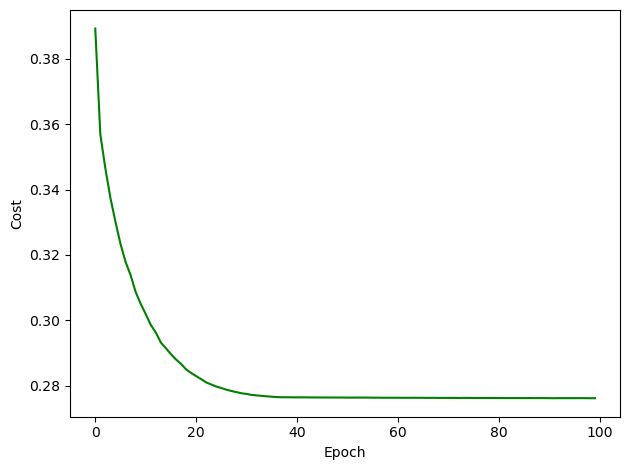

In [484]:
cost_avgs = [np.mean(x) for x in mlp3.cost_]

plt.plot(range(len(cost_avgs)),cost_avgs, color='green')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

##### **[1 points]** Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The first model, the one without scaling, basically predicts every class with roughly equal probability. This results in the model guessing that each class is class 0 which results in a 25% accuracy. This is because without scaling, the model cannot really learn which attributes are most signifigant. The second model saw a drastic improvement in accuracy and had a good converging cost function because we were able to scale the data and the model could actually start to understand that certain attributes were better predictors for the class variable than others. Finally, we one hot encoded the categorical data which resulted in an even further increase in accuracy because it led to no state being more signifigant than another state. Again this improved our accuracy because our model realized that no state should have a higher numerical value than another. Later we will be experimenting with multiple hidden layers to see how that affects our accuracy, but for now, the best model was the scaled data with the one hot encoded categorical data.

### Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

### Modeling (5 points total)
##### **[1 points]** Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

### The Network to End all Networks
The network defined below is a dynamic version of the previous networks. This means that we can pass any number of hidden layers and it will figure out the math and calculate everything correctly. This allows us to skip implementing 3 different networks and simply provide this one with a different number of hidden layers. The internal logic is the exact same as the FullyFledgedNetwork but developed from scratch as it needed to be able to handly any number of weight matrices, A values, and Z values. It is also able to print very helpful debugging information by simply passing it the verbose=True tag. This tag allows the network to print out all of the values of things such as weights, A values and Z values for each layer. Finally, we added functionality that allows us to keep track of the absolute value of the gradients that are involved in the calculations by getting the self.grad_values_ variable. This is of the form of an IxL matrix where I is the number of iterations, and L is the number of hidden layers __Note:__ We are averaging the magnitude across the different mini batches to get the magnitude for that iteration. We will be graphing these values later in the document to show that the gradient magnitude does infact converge in the network. __Note:__ The output layer is automatically added and accounted for, meaning that if you pass it an array of [30,15] it will create a 3 layer network with the first being 30 neurons, the second being 15 neurons, and the output layer being added on after that.

In [ ]:
class MiltiLayerNetwork(object):
    def __init__(self, hidden_layers,C=0.0,epochs=500,eta=0.001,random_state=None,minibatches=1,shuffle=False,alpha=0.1,
        decrease_const=0.0,verbose=False):
        np.random.seed(random_state)
        self.hidden_layers = hidden_layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatches = minibatches
        self.shuffle = shuffle
        self.alpha = alpha
        self.verbose = verbose
        self.decrease_const = decrease_const

    def _encode_labels(self,y):
        return pd.get_dummies(y).values.T

    def _glorot_init_matrix(self,shape):
        fan_in, fan_out = shape[0],shape[1]
        variance = 2.0 / (fan_in + fan_out)
        std = np.sqrt(variance)
        return np.random.normal(loc=0.0,scale=std,size=shape)

    def _initialize_weights(self):

        weights = []

        prev_size = self.n_features_ 
        curr_size = self.hidden_layers[0]
        for i in range(len(self.hidden_layers)):
            weights.append(self._glorot_init_matrix((self.hidden_layers[i],prev_size + 1)))
            curr_size = self.hidden_layers[i]
            prev_size = curr_size

        weights.append(self._glorot_init_matrix((self.n_output_,curr_size + 1)))
        if self.verbose:
            print('Weights in initialize function')
            for idx,val in enumerate(weights):
                print(f'\t{idx}: {val.shape}')

        return weights

    def _feedforward(self,X, weights):
        
        # Weights in FeedForward Function
        #     0: (30, 65)
        #     1: (15, 31)
        #     2: (25, 31)
        #     3: (10, 26)
        # A_prev: (65, 1437)
        # A_prev: (65, 1437) | Z_prev: (30, 1437)
        # i: 1 | A_prev(65, 1437) | Z_prev: (30, 1437)
        # i: 2 | A_prev(31, 1437) | Z_prev: (15, 1437)
        A = []
        Z = []
        if self.verbose:
            print('Weights in FeedForward Function')
            for idx,val in enumerate(weights):
                print(f'\t{idx}: {val.shape}')

        A_prev = self._add_bias_unit(X.T,how='row')
        if self.verbose:
            print(f"A_prev: {A_prev.shape}")

        Z_prev = weights[0] @ A_prev

        if self.verbose:
            print(f'A_prev: {A_prev.shape} | Z_prev: {Z_prev.shape}')

        A.append(A_prev)
        Z.append(Z_prev)
        for i in range(1,len(weights)):
            if self.verbose:
                print(f'i: {i} | A_prev{A_prev.shape} | Z_prev: {Z_prev.shape}')
            A_tmp = self._sigmoid(Z_prev)
            A_tmp = self._add_bias_unit(A_tmp,how='row')
            Z_tmp = weights[i] @ A_tmp
            A.append(A_tmp)
            Z.append(Z_tmp)
            A_prev = A_tmp
            Z_prev = Z_tmp
        A.append(self._sigmoid(Z_prev))

        if self.verbose:
            print('A in feed forward')
            for idx,val in enumerate(A):
                print(f'\t{idx}: {val.shape}')
            print('Z in feed forward')
            for idx,val in enumerate(Z):
                print(f'\t{idx}: {val.shape}')
        return A,Z


    def fit(self,X,y,print_progress =0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.weights = self._initialize_weights()

        # rho_W1_prev = np.zeros(self.W1.shape)
        # rho_W2_prev = np.zeros(self.W2.shape)
        rho_prev = [np.zeros(val.shape) for val in self.weights]
        self.grad_values_ = []
        self.cost_ = []

        for k in range(self.epochs):

            eta = self.eta **(1+self.decrease_const*k)
            eta = max(eta,self.eta/1000)

            if print_progress >0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                # print(ridx)
                # print(f"X: {X_data.shape} | y: {Y_enc.shape} | y_data: {y_data.shape}")

                X_data, Y_enc = X_data[ridx], Y_enc[:,ridx]

            mini = np.array_split(range(y_data.shape[0]),self.minibatches)
            mini_cost = []
            grad_costs=[]
            for idx in mini:
                A_arr, Z_arr = self._feedforward(X_data[idx],
                                                        weights=self.weights)

                cost = self._cost(A_arr[-1],Y_enc[:,idx],self.weights)
                mini_cost.append(cost)

                grads = self._get_gradient(A=A_arr,Y_enc=Y_enc[:, idx],
                                                   weights=self.weights,Z=Z_arr)
                
                rho_new = [grad * eta for grad in grads]
                # self.grad_values_.append([np.mean(np.sqrt(val**2)) for val in grads])
                # grad_costs = np.append(grad_costs,[np.average(np.sqrt(val**2)) for val in grads])
                grad_costs.append([np.average(np.sqrt(val**2)) for val in grads])
                if self.verbose:
                    print(f'Rho_new')
                    for idx,val in enumerate(rho_new):
                        print(f'{idx}: {val.shape}')
                    print(f'rho_prev')
                    for idx,val in enumerate(rho_prev):
                        print(f'{idx}: {val.shape}')
                # print(self.grad_values_)
                self.weights = [self.weights[i] - (rho_new[i] + (self.alpha * rho_prev[i]) ) for i in range(len(grads))]
                rho_prev = rho_new

            # self.grad_values_ = np.append(self.grad_values_,grad_costs)
            self.grad_values_.append([np.average(val) for val in grad_costs])
            self.cost_.append(mini_cost)
        return self
        

    def _get_gradient(self,A,Z,Y_enc,weights):
        # In Get Gradient
        # A: 4
        #     0: (65, 1437)
        #     1: (31, 1437)
        #     2: (16, 1437)
        #     3: (10, 1437)
        # Z: 3
        #     0: (30, 1437)
        #     1: (15, 1437)
        #     2: (10, 1437)
        # weights: 3
        #     0: (30, 65)
        #     1: (15, 31)
        #     2: (10, 16)
        # Curr i: 1 | V_last: (10, 1437) | W.T (16, 10)
        # Curr i: 0 | V_last: (16, 1437) | W.T (31, 15)

        if self.verbose:
                    print(f'In Get Gradient')
                    print(f'A: {len(A)}')
                    for idx,val in enumerate(A):
                        print(f'\t{idx}: {val.shape}')
                    print(f'Z: {len(Z)}')
                    for idx,val in enumerate(Z):
                        print(f'\t{idx}: {val.shape}')
                    print(f'weights: {len(weights)}')
                    for idx,val in enumerate(weights):
                        print(f'\t{idx}: {val.shape}')
        grads = []

        V_last = A[-1]-Y_enc
        grad = V_last @ A[-2].T
        grad[:,1:] += weights[-1][:,1:] * self.l2_C
        grads.append(grad)


        for i in list(reversed(range(len(weights) - 1))):
            if self.verbose:
                print(f'Curr i: {i} | V_last: {V_last.shape} | W.T {weights[i + 1].T.shape}')

            V_new = A[i + 1] * (1-A[i + 1]) * (weights[i + 1].T @ V_last)
            grad = V_new[1:,:] @ A[i].T
            grad[:,1:] += weights[i][:,1:] * self.l2_C
            V_last = V_new[1:,:]
            grads.append(grad)
        # for i in list(reversed(range(len(A) - 1,1))):
        #     V_new = A[i] * (1-A[i]) * (weights[i - 1 ].T @ V_last)
        #     grad = V_new[1:,:] @ A[i-1].T
        #     grad[:,1:] += weights[i][:,1:] * self.l2_C
        #     grads.append(grad)


        if self.verbose:
            print('Grads in get_Gradient')
            for idx,val in enumerate(list(reversed(grads))):
                print(f'\t{idx}: {val.shape}')
        return list(reversed(grads))


    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new

    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        sqrts = np.sum([np.mean(W[:, 1:] ** 2) for W in weights])
        return (lambda_) * np.sqrt(sqrts)

    def _cost(self,A3,Y_enc,weights):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3) + (1-Y_enc) * np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C,weights)
        return cost+L2_term

    def predict(self, X):
        """Predict class labels"""
        A,Z = self._feedforward(X, self.weights)
        # print(f"========== A3.shapoe {A3.shape}")
        if self.verbose:
            for idx,val in enumerate(A):
                print(f'{idx}: {np.min(val)} | {np.max(val)} | {np.mean(val)} | {np.median(val)}')
        y_pred = np.argmax(A[-1], axis=0)
        # print(f"A: {A[-1]}")
        return y_pred



##### **[1 points]** Repeat the previous step, adding support for a fourth layer.
See above explanaiton, this network is dynamic and can accept any number of hidden layers :)

##### **[1 points]** Repeat the previous step, adding support for a fifth layer.
See above explanaiton, this network is dynamic and can accept any number of hidden layers :)

### Quick Comparison between the networks

In [576]:
#Create the networks and train them
params = dict(
              C=0.0,
              epochs=100,
              eta=0.1,
              alpha=0.1,
              decrease_const=0.1,
              minibatches=len(X_train)/32,
              shuffle=True,
              random_state=4)

nn_3_layer = MiltiLayerNetwork(hidden_layers=[50,25],**params)
nn_4_layer = MiltiLayerNetwork(hidden_layers=[50,25,15],**params)
nn_5_layer = MiltiLayerNetwork(hidden_layers=[50,25,15,10],**params)

nn_3_layer.fit(X_train,y_train,print_progress=25)
nn_4_layer.fit(X_train,y_train,print_progress=25)
nn_5_layer.fit(X_train,y_train,print_progress=25)

Epoch: 100/100

In [577]:
#Test the networks
y_hat_3 = nn_3_layer.predict(X_test)
y_hat_4 = nn_4_layer.predict(X_test)
y_hat_5 = nn_5_layer.predict(X_test)

print('Accuracy of 3 Layer:',accuracy_score(y_test,y_hat_3))
print('Accuracy of 4 Layer:',accuracy_score(y_test,y_hat_4))
print('Accuracy of 5 Layer:',accuracy_score(y_test,y_hat_5))

Accuracy of 3 Layer: 0.7256600660066007
Accuracy of 4 Layer: 0.7273789878987899
Accuracy of 5 Layer: 0.7261413641364136


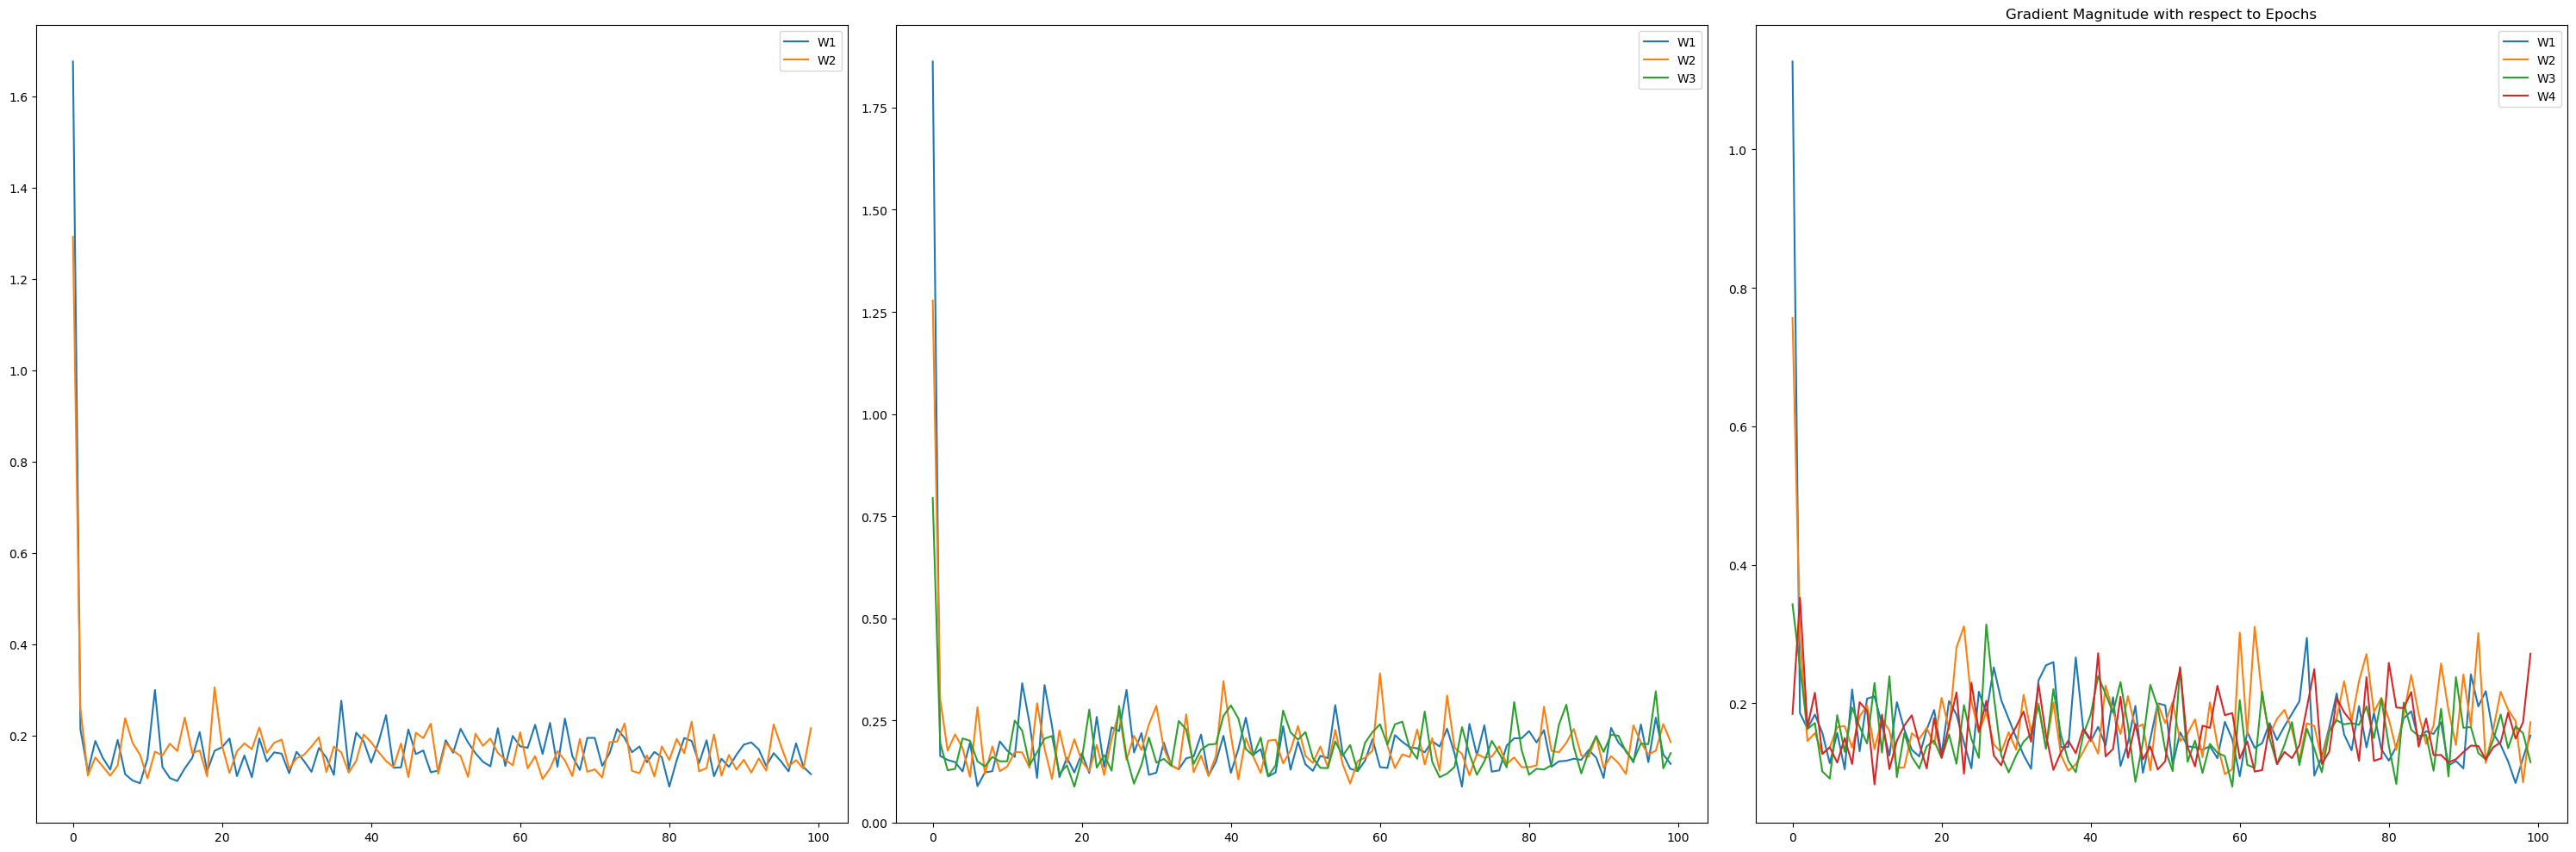

In [578]:
#Graph the gradient values as a function of the epochs
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=[30,10])
plt.title('Gradient Magnitude with respect to Epochs')

ax = ax.flatten()
# networks = [nn_3_layer,nn_4_layer,nn_5_layer]

tmp = np.array(nn_3_layer.grad_values_)
ax[0].plot(range(len(tmp)),tmp[:,0],label='W1')
ax[0].plot(range(len(tmp)),tmp[:,1],label='W2')
# ax[0].ylabel("Grad Value")
ax[0].legend()
# ax[0].xlabel("Epoch")

tmp = np.array(nn_4_layer.grad_values_)
ax[1].plot(range(len(tmp)),tmp[:,1],label='W1')
ax[1].plot(range(len(tmp)),tmp[:,0],label='W2')
ax[1].plot(range(len(tmp)),tmp[:,2],label='W3')
# ax[1].ylabel("Grad Value")
ax[1].legend()
# ax[1].xlabel("Epoch")

tmp = np.array(nn_5_layer.grad_values_)
ax[2].plot(range(len(tmp)),tmp[:,0],label='W1')
ax[2].plot(range(len(tmp)),tmp[:,1],label='W2')
ax[2].plot(range(len(tmp)),tmp[:,2],label='W3')
ax[2].plot(range(len(tmp)),tmp[:,3],label='W4')
# ax[2].ylabel("Grad Value")
ax[2].legend()
# ax[2].xlabel("Epoch")



plt.tight_layout()
plt.show()
# # tmp = nn.grad_values_.reshape(2,2,2)

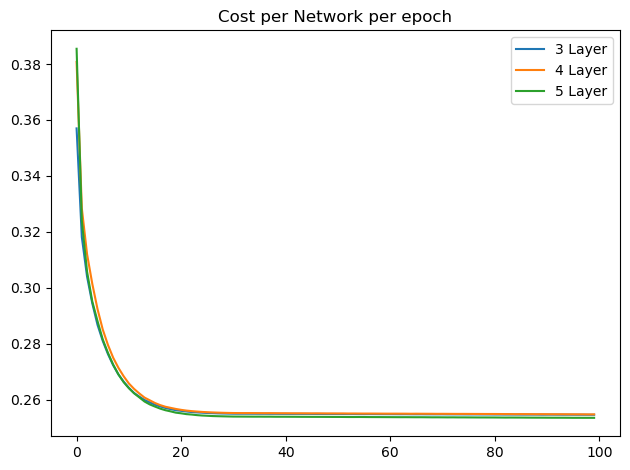

In [579]:
#Graph the gradient values as a function of the epochs

cost_avgs = [np.mean(x) for x in nn_3_layer.cost_]
plt.plot(cost_avgs,label='3 Layer')
cost_avgs = [np.mean(x) for x in nn_4_layer.cost_]
plt.plot(cost_avgs,label='4 Layer')
cost_avgs = [np.mean(x) for x in nn_5_layer.cost_]
plt.plot(cost_avgs,label='5 Layer')

plt.title('Cost per Network per epoch')

plt.legend()
plt.tight_layout()
plt.show()
# # tmp = nn.grad_values_.reshape(2,2,2)

##### **[2 points]** Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

In [565]:
class AdaptiveNetwork(MiltiLayerNetwork):
   
    def __init__(self,epsilon=1e-9,decay=0.9, **kwargs):
        self.epsilon = epsilon
        self.decay = decay
        super().__init__(**kwargs)


    def fit(self,X,y,print_progress =0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.weights = self._initialize_weights()

        
        self.sq = [np.zeros_like(weight) for weight in self.weights]

        self.grad_values_ = []
        self.cost_ = []

        for k in range(self.epochs):

            eta = self.eta **(1+self.decrease_const*k)
            eta = max(eta,self.eta/1000)

            if print_progress >0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                # print(ridx)
                # print(f"X: {X_data.shape} | y: {Y_enc.shape} | y_data: {y_data.shape}")

                X_data, Y_enc = X_data[ridx], Y_enc[:,ridx]

            mini = np.array_split(range(y_data.shape[0]),self.minibatches)
            mini_cost = []
            grad_costs=[]
            
            for idx in mini:
                A_arr, Z_arr = self._feedforward(X_data[idx],
                                                        weights=self.weights)

                cost = self._cost(A_arr[-1],Y_enc[:,idx],self.weights)
                mini_cost.append(cost)

                grads = self._get_gradient(A=A_arr,Y_enc=Y_enc[:, idx],
                                                   weights=self.weights,Z=Z_arr)
                
                
                # self.sq_grad1 = self.decay_rate * self.sq_grad1 + (1 - self.decay_rate) * grad1**2
                # self.sq_grad2 = self.decay_rate * self.sq_grad2 + (1 - self.decay_rate) * grad2**2
                # self.sq_grad3 = self.decay_rate * self.sq_grad3 + (1 - self.decay_rate) * grad3**2
                # self.sq_grad4 = self.decay_rate * self.sq_grad4 + (1 - self.decay_rate) * grad4**2
                # self.sq_grad5 = self.decay_rate * self.sq_grad5 + (1 - self.decay_rate) * grad5**2

                self.sq = [self.decay * self.sq[i] + (1-self.decay) * grads[i]**2 for i in range(len(grads))]


                self.weights = [self.weights[i] - (self.eta/np.sqrt(self.sq[i] + self.epsilon)) * grads[i] for i in range(len(grads))]
                # self.W1 -= (self.eta / np.sqrt(self.sq_grad1 + self.eps)) * grad1
                # self.W2 -= (self.eta / np.sqrt(self.sq_grad2 + self.eps)) * grad2
                # self.W3 -= (self.eta / np.sqrt(self.sq_grad3 + self.eps)) * grad3
                # self.W4 -= (self.eta / np.sqrt(self.sq_grad4 + self.eps)) * grad4
                # self.W5 -= (self.eta / np.sqrt(self.sq_grad5 + self.eps)) * grad5

                grad_costs.append([np.average(np.sqrt(val**2)) for val in grads])
                if self.verbose:
                    print(f'G shapes')
                    for idx,val in enumerate(self.G):
                        print(f'{idx}: {val.shape}')
                    
                # self.weights = [self.weights[i] -  ((self.eta)/(np.sqrt(self.epsilon * (np.diag(self.G[i])))) @ grads[i]) for i in range(len(grads))]
                
                
                
            self.grad_values_.append([np.average(val) for val in grad_costs])
            self.cost_.append(mini_cost)
        return self

In [595]:
params = dict(
              C=0.0,
              epochs=100,
              eta=0.001,
              alpha=0.1,
              epsilon=1e-9,
              decrease_const=0,
              minibatches=len(X_train)/32,
              shuffle=True,
              random_state=1)


nn_adaptive = AdaptiveNetwork(hidden_layers=[10,15,5,10],verbose=False,**params)

nn_adaptive.fit(X_train,y_train,print_progress=25)

Epoch: 100/100

[0 1 2 3]
[0 1 2 3] [0 1 2 3]
Accuracy of adaptive: 0.7318481848184818


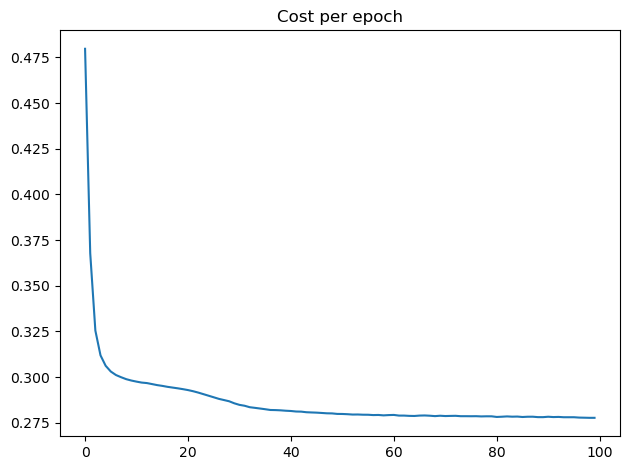

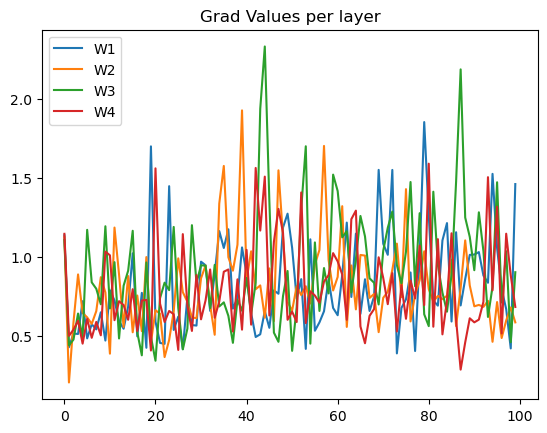

[0.0498065  0.07729655 0.08318208 ... 3.19870278 3.45363044 3.48910989]


In [597]:
y_hat_adaptive = nn_adaptive.predict(X_test)
print(np.unique(y_hat_adaptive))
print(np.unique(y_train),np.unique(y_test))

print('Accuracy of adaptive:',accuracy_score(y_test,y_hat_adaptive))

cost_avgs = [np.mean(x) for x in nn_adaptive.cost_]
plt.plot(cost_avgs)

plt.title('Cost per epoch')

plt.tight_layout()
plt.show()

tmp = np.array(nn_adaptive.grad_values_)
plt.title('Grad Values per layer')
plt.plot(range(len(tmp)),tmp[:,0],label='W1')
plt.plot(range(len(tmp)),tmp[:,1],label='W2')
plt.plot(range(len(tmp)),tmp[:,2],label='W3')
plt.plot(range(len(tmp)),tmp[:,3],label='W4')
plt.legend()
plt.show()
print(np.unique(tmp))

### Comparison between the RMSProp and the cooling learning techniques
The accuracy of the models were similar, but the cooling took much more parameter tuning to get it to get a decent accuracy while the RMSProp network was much better at converging the gradients without needing too much input from the user. The RMSprop dynamic learning technique is better because it is able to dynamically change the eta values based on the previous values of of gradients. This means that it is able to scale gradients in different ways based on how they have been behaving in the past resulting in a faster convergence rate.

### Exceptional Work (1 points total)
5000 level student: You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance.